# Interactive stream hydrograph using non-HRS gauges (manual streamflow data retrieval)

This notebook creates an interactive stream hydrograph that is used to return Earth Observation images. 

Streamflow data (stream gauging discharge values and gauging station coordinates) should be sourced for the area of interest. Please save streamflow information as a csv in your work space. Streamflow data is used to calculate the percentage exceedance statistic (the percentage of time that the streamflow value is equalled or exceeded by all other streamflow values within the data set). 

The date of streamflow measurements and date of avaliable Landsat satellite products are matched, for the location of the gauging station. A streamflow hydrograph plot is created that enables the user to click on a streamflow event and return the closest satellite image. Images are returned for a small area and a much larger area surrounding the gauging station location. There are options to save imagery in JPG or netcdf format.

The user will need to ensure the code below is updated to match the column names located in the csv (that is saved to the work space). 

"###" indicates fields that require user modification.

"##" indicates fields that may require user modification, e.g. graphic edits/preferences.

"#" indicates a cell title or description of code. No modification is required.

Code written in May 2017 by Erin Telfer with support from Leo Lymburner, Damien Ayers and Biswajit Bala. 

The notebook was completed as a graduate program project at Geoscience Australia. If you find a mistake or if you have any suggestions, please contact erin.telfer@ga.gov.au. Alternatively, please contact leo.lymburner@ga.gov.au.

In [1]:
#Import libraries
%pylab notebook

import datacube
from datacube.storage import masking
from datacube.storage.masking import mask_to_dict
from datacube.storage.storage import write_dataset_to_netcdf
from datacube.helpers import ga_pq_fuser

import pandas as pd
import xarray as xr
import numpy as np
import csv
import os
import datetime

from matplotlib.backends.backend_pdf import PdfPages
from matplotlib import pyplot as plt
import matplotlib.dates
from IPython.display import display
import ipywidgets as widgets

import rasterio
import urllib
from pyproj import Proj, transform
from dateutil import tz
from_zone = tz.tzutc()
to_zone = tz.tzlocal()
dc = datacube.Datacube(app='dc-show changes in annual mean NDVI values')

Populating the interactive namespace from numpy and matplotlib


## Read stream gauge data and coordinates from the local workspace

In [2]:
#Specify stream gauge of interest.

###User modification: Enter the ID code for the gauge of interest.
###e.g. for 'Diamantina River at Birdsville' the ID code is 'A0020101'

gauge_of_interest= '120106B'

In [3]:
##Load in the coordinates for the gauge_of_interest

#Either...Enter coordinates in GDA94 as decimal degree format 
###User modification: hash out if reading coordinates from a csv (below)
# sg_lon= 134.061
# sg_lat=-19.803

#Or... Read coordinates from a csv saved in your work space 
###User modification: hash out if entered coordinates above
###User modification: change directory and file name to where csv, that contains coordinates, is saved.
coordinates_of_interest= all_data= pd.read_csv('/g/data/r78/ext547/Prachi/location.csv') #Locate csv
coordinates_of_interest=coordinates_of_interest.set_index('ID').loc[gauge_of_interest] #find gauge of interest
sg_lon=coordinates_of_interest.X #Specify X coordinate. ###User modification: ensure name is the same as X coordinate in the csv
sg_lat=coordinates_of_interest.Y #Specify Y coordinate. ###User modification: ensure name is the same as Y coordinate in the csv

#reproject to Australian Albers
inProj = Proj(init='EPSG:4326')
outProj = Proj(init='EPSG:3577')
sg_x,sg_y = transform(inProj,outProj,sg_lon,sg_lat)

print ("Geographic: " + str(sg_lon)+', '+ str(sg_lat))
print ("Australian Albers: "+ str(sg_x)+', '+str(sg_y))

Geographic: 145.5403, -19.6813
Australian Albers: 1411574.8109075564, -2183540.8149785064


## Complete Datacube query

In [4]:
#Spatiotemporal range and wavelengths/band of interest are defined

#Temporal range is defined
start_of_epoch = '1987-01-01'
end_of_epoch =  '2014-12-31'

#Wavelengths/bands of interest are defined
bands_of_interest = ['green',
                     'red', 
                     'nir',
                     'swir1']

#Sensors of interest are defined
sensors = ['ls8',
    'ls7',
    'ls5' ] 

#Create bounding box around the location of the stream gauge
lat_max = sg_lat + 0.05
lat_min = sg_lat - 0.05
lon_max = sg_lon + 0.05
lon_min = sg_lon - 0.05

#Create query
query = {'time': (start_of_epoch, end_of_epoch)}
query['x'] = (lon_min, lon_max)
query['y'] = (lat_max, lat_min)
query['crs'] = 'EPSG:4326'

In [5]:
#Create cloud mask. This will define which pixel quality (PQ) artefacts are removed from the results.

mask_components = {'cloud_acca':'no_cloud',
'cloud_shadow_acca' :'no_cloud_shadow',
'cloud_shadow_fmask' : 'no_cloud_shadow',
'cloud_fmask' :'no_cloud',
'blue_saturated' : False,
'green_saturated' : False,
'red_saturated' : False,
'nir_saturated' : False,
'swir1_saturated' : False,
'swir2_saturated' : False,
'contiguous':True}

## Complete Datacube extraction
The extracted data is first filtered using the criteria in "mask_components".
The cloudiness of the scenes is then tested, and any scenes that do not meet the given "cloud_free_threshold" are discarded

In [6]:
#Retrieve the data for each Landsat sensor

sensor_clean = {}
cloud_free_threshold = 0.90  ###User modification: set cloud threshold. Default value is "0.90" or >90% image and <10% cloud cover
                        ###Scenes will not be retrieved that have less than the cloud threshold worth of image.

for sensor in sensors:
    #Load the NBAR and corresponding PQ
    sensor_nbar = dc.load(product= sensor+'_nbar_albers', group_by='solar_day', 
                          measurements = bands_of_interest,  **query)
    sensor_pq = dc.load(product= sensor+'_pq_albers', group_by='solar_day', 
                        fuse_func=ga_pq_fuser, **query)
    
    #Retrieve the projection information before masking/sorting
    crs = sensor_nbar.crs
    crswkt = sensor_nbar.crs.wkt
    affine = sensor_nbar.affine
    
    #Ensure there's PQ to go with the NBAR
    sensor_nbar = sensor_nbar.sel(time = sensor_pq.time)
    
    #Apply the PQ masks to the NBAR
    quality_mask = masking.make_mask(sensor_pq, **mask_components)
    good_data = quality_mask.pixelquality.loc[start_of_epoch:end_of_epoch]
    sensor_nbar2 = sensor_nbar.where(good_data)
    
    #Calculate the percentage cloud free for each scene
    cloud_free = masking.make_mask(sensor_pq, cloud_acca='no_cloud', cloud_fmask='no_cloud', 
                                   contiguous=True).pixelquality
    mostly_cloud_free = cloud_free.mean(dim=('x','y')) >= cloud_free_threshold
        
    #Discard data that does not meet the cloud_free_threshold
    mostly_good = sensor_nbar2.where(mostly_cloud_free).dropna(dim='time', how='all')
    mostly_good['product'] = ('time', numpy.repeat(sensor, mostly_good.time.size))    
    sensor_clean[sensor] = mostly_good

    print('loaded %s' % sensor) 
    

print ('complete')

loaded ls8
loaded ls7
loaded ls5
complete


In [7]:
#Check the output

sensor_clean

{'ls5': <xarray.Dataset>
 Dimensions:  (time: 214, x: 464, y: 487)
 Coordinates:
   * time     (time) datetime64[ns] 1987-07-19T23:42:27 ...
   * y        (y) float64 -2.177e+06 -2.177e+06 -2.178e+06 -2.178e+06 ...
   * x        (x) float64 1.406e+06 1.406e+06 1.406e+06 1.406e+06 1.406e+06 ...
 Data variables:
     green    (time, y, x) float64 680.0 680.0 566.0 623.0 680.0 623.0 623.0 ...
     red      (time, y, x) float64 875.0 775.0 724.0 724.0 825.0 775.0 674.0 ...
     nir      (time, y, x) float64 1.57e+03 1.57e+03 1.57e+03 1.629e+03 ...
     swir1    (time, y, x) float64 2.005e+03 1.962e+03 1.877e+03 2.005e+03 ...
     product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
 Attributes:
     crs:      EPSG:3577, 'ls7': <xarray.Dataset>
 Dimensions:  (time: 49, x: 464, y: 487)
 Coordinates:
   * time     (time) datetime64[ns] 1999-08-14T00:10:04.500000 ...
   * y        (y) float64 -2.177e+06 -2.177e+06 -2.178e+06 -2.178e+06 ...
   * x        (x) float64 1.406e+06

In [8]:
#Concatenate (join) data from different sensors together and sort so that observations are sorted 
#by time rather than sensor

nbar_clean = xr.concat(sensor_clean.values(), 'time')
time_sorted = nbar_clean.time.argsort()
nbar_clean = nbar_clean.isel(time=time_sorted)
nbar_clean.attrs['crs'] = crs
nbar_clean.attrs['affin|e'] = affine

In [9]:
#Check that the concatenation worked

nbar_clean

<xarray.Dataset>
Dimensions:  (time: 281, x: 464, y: 487)
Coordinates:
  * y        (y) float64 -2.177e+06 -2.177e+06 -2.178e+06 -2.178e+06 ...
  * x        (x) float64 1.406e+06 1.406e+06 1.406e+06 1.406e+06 1.406e+06 ...
  * time     (time) datetime64[ns] 1987-07-19T23:42:27 ...
Data variables:
    green    (time, y, x) float64 680.0 680.0 566.0 623.0 680.0 623.0 623.0 ...
    red      (time, y, x) float64 875.0 775.0 724.0 724.0 825.0 775.0 674.0 ...
    nir      (time, y, x) float64 1.57e+03 1.57e+03 1.57e+03 1.629e+03 ...
    swir1    (time, y, x) float64 2.005e+03 1.962e+03 1.877e+03 2.005e+03 ...
    product  (time) <U3 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' 'ls5' ...
Attributes:
    crs:      EPSG:3577
    affin|e:  | 25.00, 0.00, 1405775.00|\n| 0.00,-25.00,-2177450.00|\n| 0.00,...

## Process stream gauge information
Calculate the percentiles of stream flow, and sort the dataframe according to date

In [10]:
#Import streamflow data from csv saved on user's workspace
###User modification: change directory
##Change name of file, if required
all_data= pd.read_csv('/g/data/r78/ext547/Input/'+gauge_of_interest+'_discharge.csv')

In [11]:
#Calculate "percentage exceedance" (perexc) for stream flow values

#Rename flow and date columns of input to ensure consistent with code
all_data= all_data.rename(columns={'Discharge':'flow', 'Date':'date'}) ##Change to match csv input, if required
#Calculate perexc
all_data = all_data.sort_values('flow', ascending=[False]) #Sort data by flow value
all_data['rank'] = np.arange(len(all_data)) + 1 #Create rank column and values
all_data['perexc'] = 100*(all_data['rank'])/(len(all_data)+1) #Calculate probability of each rank
#Reformat datetime
all_data['date']=pd.to_datetime(all_data['date'], format='%d/%m/%Y %H:%M') #Change datetime format
all_data.date = all_data.date.map(lambda t: t.strftime('%Y-%m-%d')) #Change datetime format
all_data= all_data.sort_values(['date']) #Sort data by date

## Return just the time and sensor product information from the Datacube extraction

In [12]:
product_time = nbar_clean[['time', 'product']].to_dataframe() #Add time and product to dataframe
product_time.index = product_time.index + pd.Timedelta(hours=10) #Roughly convert to local time
product_time.index = product_time.index.map(lambda t: t.strftime('%Y-%m-%d')) #Remove Hours/Minutes Seconds by formatting into a string

## Match the date of stream flow data to the date where satellite information exists

In [13]:
subset_data = pd.merge(all_data, product_time, left_on= 'date', 
                       right_index=True, how='inner') #Match dates and merge

In [14]:
subset_data['date']=pd.to_datetime(subset_data['date'], format='%Y/%m/%d %H:%M:%S') #Change datetime format

In [15]:
#Save the subset of matched data to csv
###User modification: edit directory
subset_data.to_csv('/g/data/r78/ext547/Prachi/Output/'+gauge_of_interest+'_match.csv')

# Create interactive hydrograph plot

In [16]:
#Create date variables for axis on hydrograph plot to enable automatic axis scaling

subset_dates = subset_data['date'] #Define matched dates
all_dates=all_data['date']         #Define all dates

min_date=min(subset_data.date) #Create minimum date value to enable automatic axis scaling
max_date=max(subset_data.date) #Create maximum date value to enable automatic axis scaling

In [17]:
all_data.flow=all_data.flow.convert_objects(convert_numeric=True)
subset_data.flow=subset_data.flow.convert_objects(convert_numeric=True)

/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:1: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  """Entry point for launching an IPython kernel.
/g/data/v10/public/modules/agdc-py3-env/20170427/envs/agdc/lib/python3.6/site-packages/ipykernel_launcher.py:2: FutureWarning: convert_objects is deprecated.  Use the data-type specific converters pd.to_datetime, pd.to_timedelta and pd.to_numeric.
  


In [18]:
#Create flow variables for axis on hydrograph plot to enable automatic axis scaling

max_flow=max(all_data.flow) #Define maximum flow for matched flow
min_flow=min(all_data.flow) #Define minimum flow for matched flow

min_flow= (min_flow-(0.01*max_flow)) #Create minimum flow value to enable automatic axis scaling
 ##User should change flow multiplier if required
max_flow= (max_flow+(0.08*max_flow)) #Create maximum flow value to enable automatic axis scaling
 ##User should change flow multiplier if required

<IPython.core.display.Javascript object>


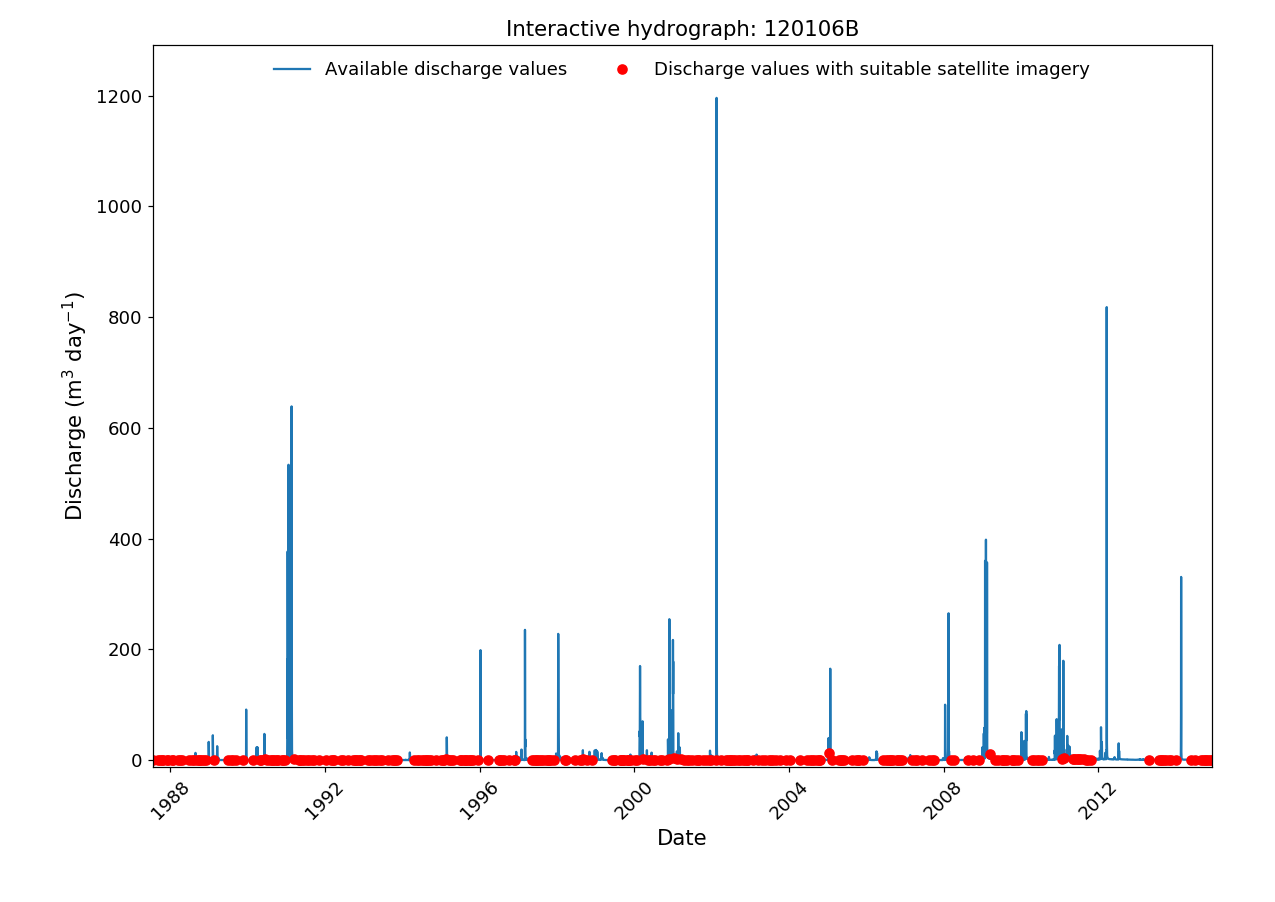

In [22]:
#Create interactive hydrograph

#create widget that enables interaction with hydrograph
w = widgets.HTML("Event information appears here when you click on the figure")
def callback(event):
    global time_int, discharge_int, devent
    devent = event
    time_int = event.xdata
    discharge_int= event.ydata
    time_int_ = time_int.astype(datetime64[D])
    w.value = 'time_int: {}'.format(time_int)

#Set up plot
fig = plt.figure(figsize=(11.69,8.27)) #Edit size of plot ##User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive hydrograph: '+gauge_of_interest, size=14) #Plot title ##User should format if required
plt.show() #Plot setup
display(w) #Plot setup
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99) #Make border white ##User should format if required

#Plot flow values
matplotlib.pyplot.plot_date(all_dates,all_data['flow'], '-', label= 'Available discharge values') #plot all discharge values ##User should format series if required

matplotlib.pyplot.plot_date(subset_dates, subset_data['flow'], 'ro', 
                            label='Discharge values with suitable satellite imagery') #plot matched discharge values ##User should format series if required

#Axis details
firstyear = min_date ###User modification: set period of interest use "min_date" variable for automatic scaling
lastyear = max_date ###User modification: set period of interest use "max_date" variable for automatic scaling
plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
plt.yticks(size=12) #format size of date labels ##User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)', size=14) #Set Y label
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=2, loc=9, fontsize=12) #Set legend location on plot ##User should format if required

In [23]:
#Save figure

###User modification: edit directory to save figure
%cd /g/data/r78/ext547/Prachi/Output/
plt.savefig('Hydrograph_'+gauge_of_interest+'.jpg') ##User should format file name  if required 

/g/data1/r78/ext547/Prachi/Output


In [24]:
#Show values for click on interactive graph
print ('Clicked discharge: ' + str(discharge_int) + ' m3')
print ('Clicked date as int: ' + str(time_int))

Clicked discharge: -4.73450151564 m3
Clicked date as int: 728410.591288


In [25]:
# Define the closest real value from the clicked point on the interactive graph. For example, 
# find the exact date of the satellite pass or the exact discharge or flow exceedance value 
# and then format to use as title for images

#Date
time_slice = matplotlib.dates.num2date(time_int).date() #Convert clicked int to datetime format
time_slice=str(time_slice) #Convert clicked value to str
time_slice= pd.to_datetime(time_slice, format='%Y-%m-%d') #Convert clicked value to correct datetime format
subset_data['date'] = pd.to_datetime(subset_data['date'], format='%Y-%m-%d')  #Convert actual value to correct datetime
subset_data['difference']=(subset_data['date'] - time_slice).abs() #Find difference between clicked and actual
time_slice=subset_data.iloc[argsort(subset_data['difference'])].date #sort by difference and locate value
time_slice= (list(time_slice)[0]) #Choose value with the smallest difference between clicked and actual values
time_slice= str(time_slice)  #Convert to string
time_slice=datetime.datetime.strptime(time_slice,'%Y-%m-%d  %H:%M:%S') #Convert to datetime
time_slice_actual=time_slice #Make new date variable
time_slice_t1=time_slice_actual+datetime.timedelta(days=-2) #Make date variable two days before actual date 
time_slice_t2=time_slice_actual+datetime.timedelta(days=2) #Make date variable two days after actual date 

#Flow
discharge_title= subset_data.iloc[argsort(subset_data['difference'])].flow #Return actual flow value
discharge_title= (list(discharge_title)[0]) #Specify just actual flow value
discharge_title= str(discharge_title) #Convert to string
discharge_title2= float(discharge_title) #Convert to float
discharge_title2=str("{0:.2f}".format(discharge_title2))  #Reformat

#Percentage exceedance
perexc_title= subset_data.iloc[argsort(subset_data['difference'])].perexc #Return actual percentage exceedance value
perexc_title= (list(perexc_title)[0]) #Specify just actual percentage exceedance value
perexc_title= str(perexc_title) #Convert to string
perexc_title2= float(perexc_title) #Convert to float
perexc_title2=str("{0:.2f}".format(perexc_title2)) #Reformat

#Satellite
satellite_type=subset_data.iloc[argsort(subset_data['difference'])] #Return actual satellite type
satellite_type=satellite_type['product'] #Return actual satellite type
satellite_type= (list(satellite_type)[0])#Specify just actual satellite type
satellite_type= str(satellite_type) #Convert to string
satellite_type=  satellite_type +'_nbar_albers' #Rename


print ('Actual observation date: ' +str(time_slice_actual))
print ('Discharge: ' +str(discharge_title2) +' m3')
print ('Percent exceedance: '+ str(perexc_title2) + '%')
print ('Product: '+ str(satellite_type))

Actual observation date: 1995-04-21 00:00:00
Discharge: 0.01 m3
Percent exceedance: 66.76%
Product: ls5_nbar_albers


<IPython.core.display.Javascript object>


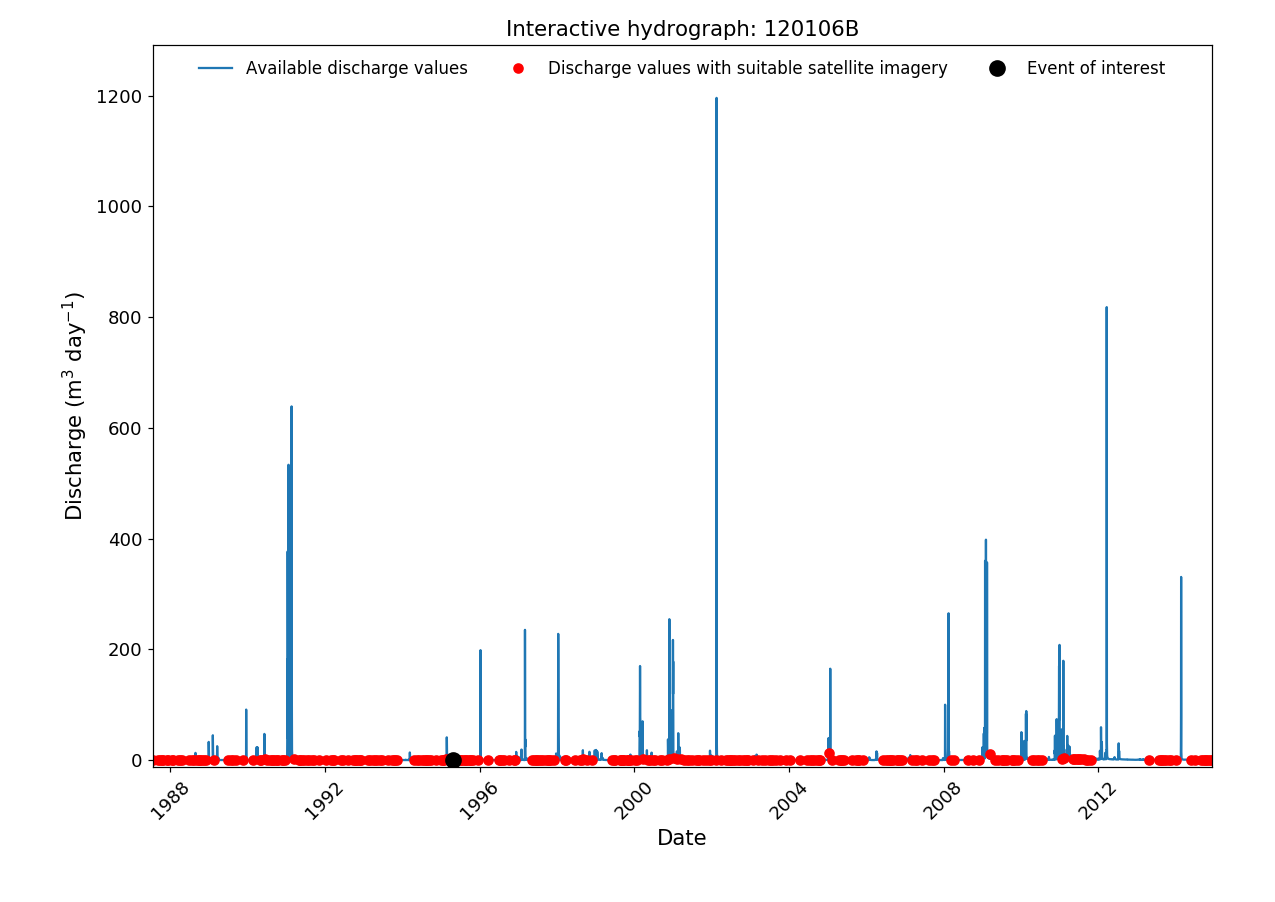

In [26]:
#Create a hydrograph with the date of interest highlighted

#Set up plot 
fig = plt.figure(figsize=(11.69,8.27)) #Edit size of plot ##User should format as required
fig.canvas.mpl_connect('button_press_event', callback) #Plot setup
plt.title('Interactive hydrograph: '+gauge_of_interest, size=14) #Plot title ##User should format if required
plt.show() #Plot setup
display(w) #Plot setup
plt.subplots_adjust(left=0.12, right=0.95, top=0.95, bottom=0.15) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99) #Make border white ##User should format if required

#plot
matplotlib.pyplot.plot_date(all_dates,all_data['flow'], '-', label= 'Available discharge values') #plot all discharge values ##User should format series if required

matplotlib.pyplot.plot_date(subset_dates, subset_data['flow'], 'ro', 
                            label='Discharge values with suitable satellite imagery') #plot matched discharge values ##User should format series if required

matplotlib.pyplot.plot_date(time_slice_actual,discharge_title2, 'ko',
                            label='Event of interest', ms=10) #plot event of interest ##User should format series if required

#axis details
plt.axis([firstyear , lastyear ,min_flow, max_flow], 'tight') #Set axis 
plt.yticks(size=12) #format size of date labels ##User should format if required
plt.xticks(rotation=45,size=12) #Rotate and format size of date labels ##User should format if required
plt.ylabel('Discharge (m$^3$ day$^{-1}$)',size=14) #Set Y label
plt.xlabel('Date', size=14) #Set X label
plt.legend(edgecolor ='none', ncol=3, loc=9, fontsize=11) #Set legend location on plot ##User should format if required


In [27]:
#Save figure

###User modification: edit directory to save figure
%cd /g/data/r78/ext547/Prachi/Output/
plt.savefig('Hydrograph_'+gauge_of_interest+'_'+str(time_slice_actual)[0:-9]+'.jpg')## User should format file name if required 

/g/data1/r78/ext547/Prachi/Output


In [ ]:
stop here

# Creation of image showing a small area directly around stream gauge

In [28]:
#Prepare imagery
rgb = nbar_clean.sel(time =time_slice_actual, method = 'nearest').to_array(dim='color').sel(color=[
    'swir1','nir', 'green']).transpose('y', 'x', 'color')
fake_saturation = 6000.0
rgb = rgb.astype('double')
clipped_visible = rgb.where(rgb<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

<IPython.core.display.Javascript object>


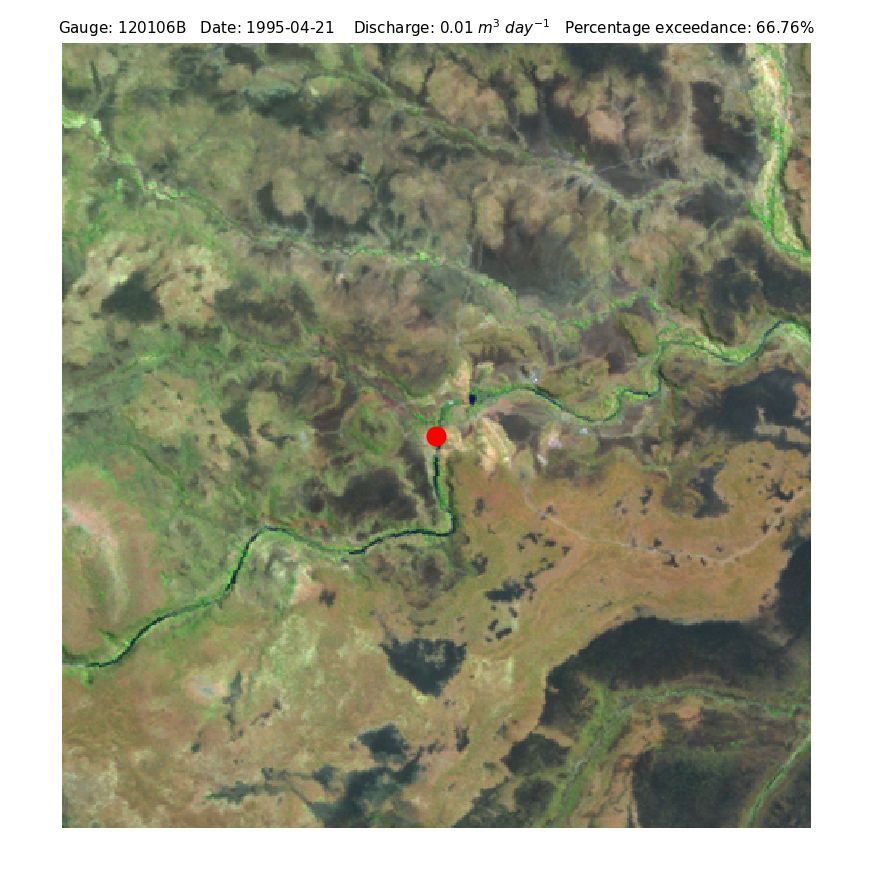

In [29]:
#Create small area image for the event of interest

fig = plt.figure(figsize =(8,8)) #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99)#Make border white ##User should format if required
plt.axis('off')#remove axis ##User should delete code if required

#Edit plot title ##User should format as required
plt.title('Gauge: '+gauge_of_interest +'   Date: '+str(time_slice_actual)[0:-9]  + 
          '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
          '   Percentage exceedance: '+ str(perexc_title2) + '%', size=10) 

#Add marker to show location of stream gauge 
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=150)
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                  scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

In [30]:
#Save figure
###User modification: edit directory to save figure
%cd /g/data/r78/ext547/Prachi/Output/ 
plt.savefig('H_'+gauge_of_interest +'_' +str(time_slice_actual)[0:-9] +'_PE'+ str(perexc_title2) +
            '_D'+str(discharge_title2) +'_small'+ '.jpg') ##User should format file name, if required 

/g/data1/r78/ext547/Prachi/Output


# Creation of image showing a large area around the stream gauge

In [31]:
#Create Datacube query for event of interest

#Define date for event of interest
start_of_epoch = time_slice_t1.strftime("%Y %m, %d") 
end_of_epoch = time_slice_t2.strftime("%Y %m, %d")

#Define area of interest 
###User modification: change area of interest to suit gauge location in relation to satellite pass
lat_max = sg_lat+ 0.6 #up
lat_min = sg_lat- 0.6 #down
lon_max = sg_lon+ 0.8 #right
lon_min = sg_lon- 0.4 #left

#Create query 
query2 = {
    'time': (start_of_epoch, end_of_epoch)
        }
query2['x'] = (lon_min, lon_max)
query2['y'] = (lat_max, lat_min)
query2['crs'] = 'EPSG:4326'
print (query2)

{'time': ('1995 04, 19', '1995 04, 23'), 'x': (145.1403, 146.34030000000001), 'y': (-19.081299999999999, -20.281300000000002), 'crs': 'EPSG:4326'}


In [32]:
#Load image data for event of interest   
image_of_interest = dc.load(product= satellite_type, group_by='solar_day',
                            measurements = bands_of_interest,  **query2)

In [33]:
#Prepare imagery
rgb2 = image_of_interest.to_array(dim='color').sel(color=['swir1',
                                                          'nir', 'green']).squeeze().transpose('y', 'x', 'color')
fake_saturation = 6000
clipped_visible = rgb2.where(rgb2<fake_saturation).fillna(fake_saturation)
max_val = clipped_visible.max(['y', 'x'])
scaled = (clipped_visible / max_val)

In [37]:
#Create large area image for event of interest

fig = plt.figure(figsize =(10,10))  #Edit size of plot ##User should format as required
plt.subplots_adjust(left=0.05, right=0.95, top=0.95, bottom=0.05) #Set border dimensions  ##User should format if required
fig.patch.set_facecolor('white') #Make border white ##User should format if required
fig.patch.set_alpha(0.99) #Make border white ##User should format if required
plt.axis('off') #remove axis ##User should delete code if required

#Edit plot title ##User should format as required
# plt.title('Gauge: '+gauge_of_interest +'    Date: '+str(time_slice_actual)[0:-9]  + 
#           '    Discharge: ' + discharge_title2+' $m^3$ $day^{-1}$' +
#           '   Percentage exceedance: '+ str(perexc_title2) + '%', size=22)

#Add marker to show location of stream gauge 
plt.scatter(x = [sg_x], y = [sg_y], c= 'r', marker = 'o', s=500)
plt.imshow(scaled, interpolation = 'nearest',
           extent=[scaled.coords['x'].min(), scaled.coords['x'].max(), 
                  scaled.coords['y'].min(), scaled.coords['y'].max()])
plt.show() #Create plot

<IPython.core.display.Javascript object>

In [38]:
#Save figure
###User modification: edit directory to save figure
%cd /g/data/r78/ext547/Output/Hydrograph/ 
plt.savefig('H_'+gauge_of_interest +'_' +str(time_slice_actual)[0:-9] +'_PE'+ str(perexc_title2) +
            '_D'+str(discharge_title2) +'_large'+ '.jpg') ## User should format file name if required 

/g/data1/r78/ext547/Output/Hydrograph


In [ ]:
stop here

# If required, save as image in netcdf format

In [40]:
#Retrieve the original nbar dataset attributes (crs)

attrs = image_of_interest #set up variable attributes to hold the attributes

#get the band information
bands = attrs.data_vars.keys()
print (bands)
for i in bands:
    #drop band data, retaining just the attributes
    attrs =attrs.drop(i)
    
#set up new variable called ndvi_var, and assign attributes to it in a dictionary
image_var = {'scaled':''}
image_output = attrs.assign(**image_var)
image_output['scaled'] = scaled
print (image_output)
image_output2 = image_output.scaled.to_dataset(dim='color')

#print image output
image_output2.attrs['crs'] = image_output.crs

KeysView(Data variables:
    green    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    red      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    nir      (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...
    swir1    (time, y, x) int16 -999 -999 -999 -999 -999 -999 -999 -999 -999 ...)
<xarray.Dataset>
Dimensions:  (color: 3, x: 5558, y: 5842)
Coordinates:
    time     datetime64[ns] 1995-04-20T23:25:30.500000
  * y        (y) float64 -2.113e+06 -2.113e+06 -2.113e+06 -2.113e+06 ...
  * x        (x) float64 1.363e+06 1.363e+06 1.363e+06 1.363e+06 1.363e+06 ...
  * color    (color) <U5 'swir1' 'nir' 'green'
Data variables:
    scaled   (y, x, color) float64 -0.1665 -0.1665 -0.1665 -0.1665 -0.1665 ...
Attributes:
    crs:      EPSG:3577


In [42]:
#Create netcdf
###User modification: edit directory and file name
outfile = '/g/data/r78/ext547/Output/netcdf/'+ str(time_slice_actual)[0:-9] +'.nc' 
#Create file
write_dataset_to_netcdf(image_output2,  variable_params={'scaled': {'zlib':True}}, filename=outfile) 

print ('wrote: '+outfile+' to netcdf')

wrote: /g/data/r78/ext547/Output/netcdf/1995-04-21.nc to netcdf
